this code is inspired from kaggle to perform pancreatic cancer detection using matplotlib, seaborn, gridsearchcv, pipeline etc

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('urinary_biomarkers.csv')

In [18]:
cols = df.columns.to_list()
df.diagnosis = df.diagnosis == 3
df.sex = df.sex.map({'M':0,'F':1})

df = df[['creatinine',
         'plasma_CA19_9',
         'age',
         'sex',
         'LYVE1',
         'REG1B',
         'TFF1',
         'diagnosis']].copy()
df.head(10)

,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,diagnosis
0,1.83222,11.7,33,1,0.893219,52.94884,654.282174,False
1,0.97266,NaN,81,1,2.037585,94.46703,209.488250,False
2,0.78039,7.0,51,0,0.145589,102.36600,461.141000,False
3,0.70122,8.0,61,0,0.002805,60.57900,142.950000,False
4,0.21489,9.0,62,0,0.000860,65.54000,41.088000,False
5,0.84825,NaN,53,0,0.003393,62.12600,59.793000,False
6,0.62205,NaN,70,0,0.174381,152.27700,117.516000,False
7,0.89349,11.0,58,1,0.003574,3.73000,40.294000,False
8,0.48633,NaN,59,1,0.001945,7.02100,26.782000,False
9,0.61074,24.0,56,1,0.278778,83.92800,19.185000,False


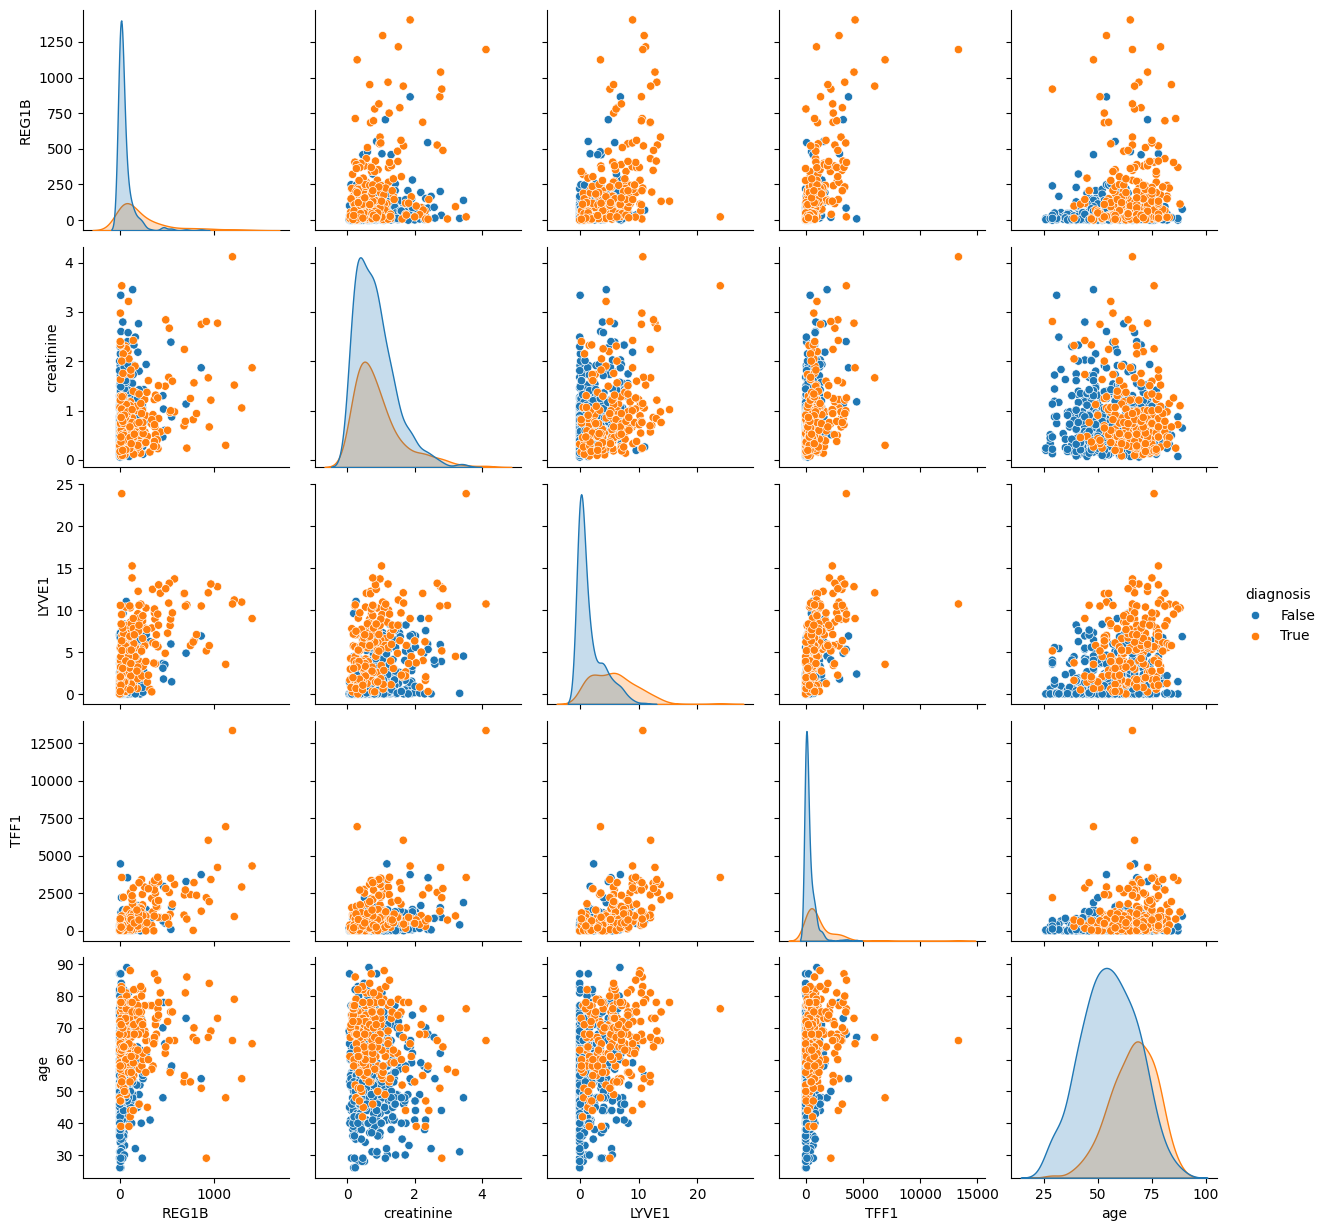

In [19]:
sns.pairplot(data = df,vars = ['REG1B','creatinine','LYVE1','TFF1','age'],hue = 'diagnosis',diag_kind='kde')

From the pairplot above we can see that, the higher the value of the variables like REG1B,TFF1,LYVE1, the higher the probability of having the disease

<Axes: >

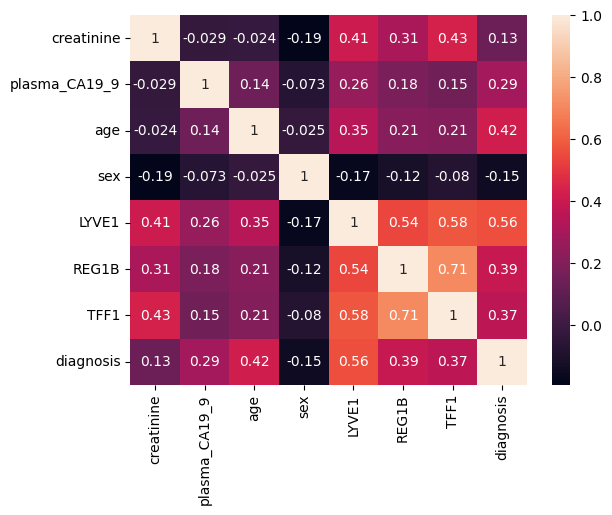

In [20]:
corr = df.dropna().corr()
sns.heatmap(corr,annot=True)

Observing the above we can see that LYVE1 has the highest correlation against diagnosis

Best Parameters:  {'rf__max_depth': None, 'rf__n_estimators': 100}
Best Score:  0.8520905923344948
Accuracy of the predictions:  0.8700564971751412


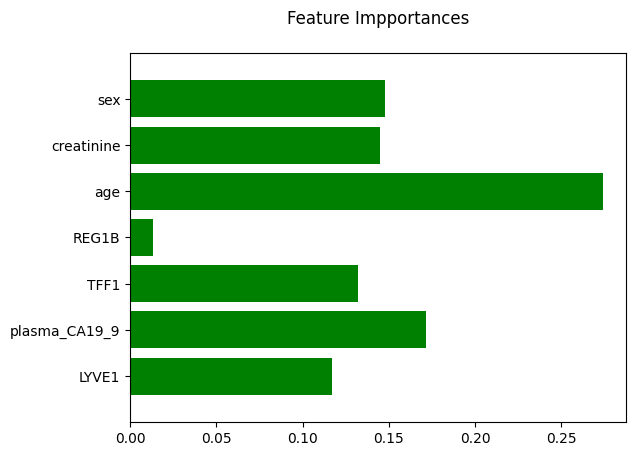

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = df.drop(columns='diagnosis')
y = df['diagnosis']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)

#create a pipline with imputer and classifier
pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy = 'mean')),
    ('rf',RandomForestClassifier())])

#create param_grid which is a dictionary with parameters to tune
#define the grid parameter to search over
param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None,5,10]
}

grid_search  = GridSearchCV(pipeline,param_grid,cv = 10)
#fit the grid search to the training data
grid_search.fit(X_train,y_train)

print("Best Parameters: ",grid_search.best_params_)
print("Best Score: ",grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy of the predictions: ",accuracy_score(y_test,y_pred))

#Plotting feature importances
importance = best_model.named_steps['rf'].feature_importances_

#Sorting the feature impportances in descending order
indices = np.argsort(importance)[::-1]

plt.figure()
plt.title("Feature Importances\n")
plt.barh(range(X_train.shape[1]),importance,color = 'g')
plt.yticks(range(X_train.shape[1]),X_train.columns[indices])
plt.ylim([-1,X_train.shape[1]])
plt.show()


In [25]:
from sklearn.metrics import cohen_kappa_score,classification_report,balanced_accuracy_score,roc_auc_score,accuracy_score

pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'mean')),
                     ('scaler',StandardScaler()),
                     ('rf',RandomForestClassifier(n_estimators = 100,random_state = 42))
                     ])
pipeline.fit(X_train,y_train)

cv_scores = cross_val_score(pipeline,X_train,y_train,cv = 5,scoring = 'accuracy')
mean_cv = np.mean(cv_scores)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)

kappa = cohen_kappa_score(y_test,y_test_pred)
auc = roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,-1])
print("Random Forest Model")
print("Train Accuracy: ",train_accuracy)
print("Test Accuracy: ",test_accuracy)
print("Cohen's Kappa: ",kappa)
print("AUC: ",auc)
print("Classification Report: ",classification_report(y_test,y_test_pred))
print("Balanced Accuracy: ",balanced_accuracy_score(y_test,y_test_pred))


Random Forest Model
Train Accuracy:  1.0
Test Accuracy:  0.8587570621468926
Cohen's Kappa:  0.6615161018893904
AUC:  0.943076923076923
Classification Report:                precision    recall  f1-score   support

       False       0.90      0.90      0.90       125
        True       0.75      0.77      0.76        52

    accuracy                           0.86       177
   macro avg       0.83      0.83      0.83       177
weighted avg       0.86      0.86      0.86       177

Balanced Accuracy:  0.8326153846153846
